# MNIST Classification

In [1]:
#!/usr/bin/env python3
import numpy as np
from scipy.misc import imshow
from matplotlib import pyplot as plt
from random import randint
from sklearn.metrics import confusion_matrix
import pandas as pd

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


## Data Extraction

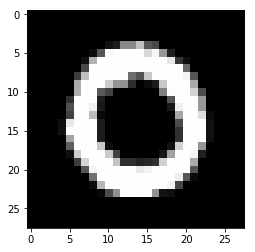

In [2]:
array = np.loadtxt("mnist.csv", skiprows = 1, delimiter=',')
plt.imshow(array[1,1:785].reshape(28,28), cmap='gray')
plt.show()

In [3]:
array.shape

(42000, 785)

## Data Preparation

In [4]:
#data separation
# the separation may not be optimal since we favor 
#the training and test sets to fulfill the requirements
nb_img = 42000
nb_class = 10
nb_train = int(nb_img * 0.7) #70% of data for training
nb_test = int(nb_img * 0.25)
nb_valid = nb_img - nb_train - nb_test
id = randint(0, nb_img-1)
train_set = array[id]
idx = np.arange(nb_img)
np.random.shuffle(idx)
idx_train = idx[0:nb_train-1]
idx_test = idx[nb_train+1:nb_train+nb_test]
idx_valid = idx[nb_train+nb_test+1:]
set_train = array[idx_train]
set_test = array[idx_test]
set_valid = array[idx_valid]

In [5]:
X_train = set_train[:,1:].reshape(set_train.shape[0], 28, 28, 1)
X_train/=255
X_test = set_test[:,1:].reshape(set_test.shape[0], 28, 28, 1)
X_test/=255
X_valid = set_valid[:,1:].reshape(set_valid.shape[0], 28, 28, 1)
X_valid/=255
Y_train = np_utils.to_categorical(set_train[:,0], nb_class)
Y_test = np_utils.to_categorical(set_test[:,0], nb_class)
Y_valid = np_utils.to_categorical(set_valid[:,0], nb_class)

In [6]:
df = pd.DataFrame(data=set_test)
print(df.groupby([0]).size())

0
0.0    1085
1.0    1133
2.0    1075
3.0    1081
4.0    1021
5.0     925
6.0    1017
7.0    1116
8.0    1014
9.0    1032
dtype: int64


## Classification

In [27]:
nb_filters = 48
nb_conv = 3
nb_pool = 2
images_rows = 28 #use origninal images
images_cols = 28
nb_categories = 10

#VGG

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', kernel_initializer='glorot_uniform', input_shape=(images_rows, images_cols, 1)))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
    
model.add(Conv2D(nb_filters*2, (nb_conv, nb_conv), activation='relu', kernel_initializer='glorot_uniform'))
model.add(Conv2D(nb_filters*2, (nb_conv, nb_conv), activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
    
model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.25))
model.add(Dense(nb_categories, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 48)        480       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 48)        20784     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 96)        41568     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 96)          83040     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536)              0         
__________

In [35]:
model.fit(
    X_train, Y_train, 
    epochs = 20, #only last final epochs are shown below
    batch_size = 64,
    shuffle = True,
    verbose = 1,
    callbacks = [EarlyStopping(monitor='loss', patience=5, mode='min')],
    validation_data = (X_valid, Y_valid)
)

Train on 29398 samples, validate on 2100 samples
Epoch 1/5
29398/29398 [==============================] - 101s 3ms/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.0491 - val_acc: 0.9895
Epoch 2/5
29398/29398 [==============================] - 104s 4ms/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.0645 - val_acc: 0.9886
Epoch 3/5
29398/29398 [==============================] - 105s 4ms/step - loss: 0.0057 - acc: 0.9984 - val_loss: 0.0715 - val_acc: 0.9876
Epoch 4/5
29398/29398 [==============================] - 104s 4ms/step - loss: 0.0049 - acc: 0.9987 - val_loss: 0.0637 - val_acc: 0.9886
Epoch 5/5
29398/29398 [==============================] - 104s 4ms/step - loss: 0.0045 - acc: 0.9988 - val_loss: 0.0528 - val_acc: 0.9905


In [36]:
score = model.evaluate(X_test, Y_test)
print('Test accuracy: ', score[1])

10499/10499 [==============================] - 12s 1ms/step
Test accuracy:  0.992189732355


In [37]:
y_predict = model.predict_classes(X_test)
cm = confusion_matrix(set_test[:,0], y_predict)
print("TPR: ", np.trace(cm)/nb_test*100)
print("FPR: ", (nb_test-np.trace(cm))/nb_test*100)

TPR:  99.2095238095
FPR:  0.790476190476


Due to the randomness of the data sets, the fitted model as well as the prediction accuracy may change at each run.
The fitting can be improved by using a larger training dataset and/or deeper NN (maybe with more features).

## Adding Strategy

In [38]:
predictions = model.predict(X_test, batch_size=64)

y_pre = y_predict
for i in range(predictions.shape[0]):
    if np.amax(predictions[i,:]) < 0.9999999:
        y_pre[i] = -1

In [39]:
cm = confusion_matrix(set_test[:,0], y_pre)
print("TPR(%): ", np.trace(cm)/np.sum(cm[:,1:])*100)
print("FPR(%): ", (np.sum(cm[:,1:])-np.trace(cm))/np.sum(cm[:,1:])*100)
print("recall(%): ", np.sum(cm[:,1])/nb_train*100)

TPR(%):  99.9156118143
FPR(%):  0.084388185654
recall(%):  3.45930133678


The idea here is to use threshold(s) to guard from false positive. The overall thresholding is shown here. Similarly, this can be implemented at each class level to lower the recall rate due to the class discrepencies. However, the latter was not demonstrated here due to lack of time.